# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

# preprocessing data

In [2]:
import pandas_ta as ta

In [3]:
path_to_file = "btc.csv"

In [4]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)

btc.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


<AxesSubplot:title={'center':'Bitcoin Weighted Price'}, xlabel='date'>

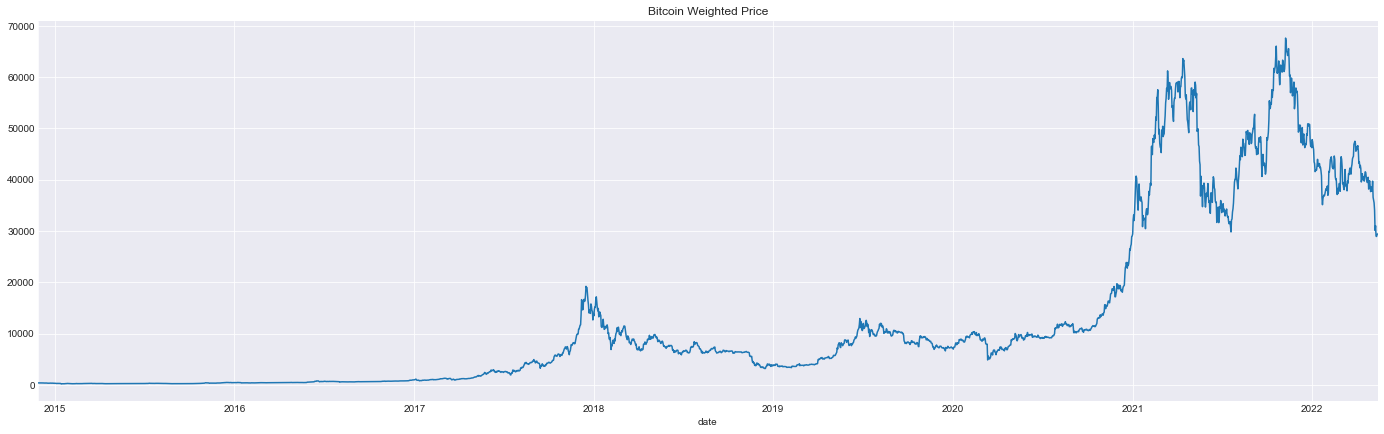

In [5]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc.close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [6]:

btc['close_log'] =  np.log(btc['close'])
btc['diff1_log'] = btc['close_log'].diff()
btc['diff7_log'] = btc['close_log'].diff(7)
btc['diff30_log'] = btc['close_log'].diff(30)
btc['diff1'] = btc['close'].diff()
btc['diff7'] = btc['close'].diff(7)
btc['diff30'] = btc['close'].diff(30)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']
btc['rsi'] = ta.rsi(btc['close'],length=14)
btc['mom'] = ta.mom(btc['close'],length=10)
btc['target_log'] = btc['close_log'].shift(-1)
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [7]:
btc.tail()

,open,high,low,close,Volume BTC,close_log,diff1_log,diff7_log,diff30_log,diff1,diff7,diff30,rsi,mom,target_log,target
date,,,,,,,,,,,,,,,,
2022-05-09,34051.20,34224.35,30015.00,30082.00,7631.121662,10.311682,-0.123183,-0.247277,-0.351861,-3943.50,-8439.01,-12685.89,24.506606,-8511.42,10.341742,30999.97
2022-05-10,30066.48,32650.00,29731.03,30999.97,7402.302313,10.341742,0.030059,-0.196468,-0.306865,917.97,-6729.98,-11133.88,28.604810,-6639.83,10.275051,29000.00
2022-05-11,31002.27,32148.15,27757.77,29000.00,11180.848836,10.275051,-0.066690,-0.313683,-0.309634,-1999.97,-10685.23,-10524.86,25.373064,-9488.34,10.271465,28896.19
2022-05-12,28999.99,30090.70,25401.05,28896.19,16578.810599,10.271465,-0.003586,-0.234532,-0.327603,-103.81,-7637.74,-11201.27,25.213830,-9624.82,10.283252,29238.81
2022-05-13,28932.69,30974.60,28686.37,29238.81,6010.273639,10.283252,0.011787,-0.208556,-0.341672,342.62,-6780.41,-11908.93,26.845615,-8491.14,10.288993,29407.14


In [8]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler_t = MinMaxScaler(feature_range=(0, 1))
# scaler_tlog = MinMaxScaler(feature_range=(0, 1))
# StandardScaler
scaler = StandardScaler()
scaler_t = StandardScaler()
scaler_tlog = StandardScaler()


btc.diff1_log = scaler.fit_transform(btc.diff1_log.values.reshape(-1,1))
btc.diff7_log = scaler.fit_transform(btc.diff7_log.values.reshape(-1,1))
btc.diff30_log = scaler.fit_transform(btc.diff30_log.values.reshape(-1,1))
btc.diff1 = scaler.fit_transform(btc.diff1.values.reshape(-1,1))
btc.diff7 = scaler.fit_transform(btc.diff7.values.reshape(-1,1))
btc.diff30 = scaler.fit_transform(btc.diff30.values.reshape(-1,1))
btc.rsi = scaler.fit_transform(btc.rsi.values.reshape(-1,1))
btc.mom = scaler.fit_transform(btc.mom.values.reshape(-1,1))

btc.close = scaler_t.fit_transform(btc.close.values.reshape(-1,1))
btc.target = scaler_t.transform(btc.target.values.reshape(-1,1))

btc.close_log = scaler_tlog.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler_tlog.transform(btc.target_log.values.reshape(-1,1))


In [9]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

# creat data lstm

In [10]:
df_train_.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'close_log', 'diff1_log',
       'diff7_log', 'diff30_log', 'diff1', 'diff7', 'diff30', 'rsi', 'mom',
       'target_log', 'target'],
      dtype='object')

In [13]:
df_train = df_train_[:][['open', 'high', 'low', 'close', 'Volume BTC', 'target']]
df_test = df_test_[:][['open', 'high', 'low', 'close', 'Volume BTC', 'target']]
df_test.head(2)

,open,high,low,close,Volume BTC,target
date,,,,,,
2022-03-15,39688.55,39896.13,38142.35,1.591603,1638.684030,1.701328
2022-03-16,39302.80,41693.97,38865.67,1.701328,5987.103889,1.690622


In [14]:
# many to one

look_back_ = 5

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
            target = i[-1] / prev_days[0][3]
            sequential_data.append([np.array(prev_days), target])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)
trainX, trainY = trainX[2100:], trainY[2100:]
testX, testY = dataset_generator_lstm(df_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (530, 5, 5)
trainY:  (530,)
testY:  (56, 5, 5)
testY (56,)


# train

In [19]:
regressor = Sequential()

regressor.add(LSTM(units = 256,return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# 

regressor.add(LSTM(units = 128, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))

regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 256)            268288    
                                                                 
 dropout_2 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 465,537
Trainable params: 465,537
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


# history = regressor.fit(trainX[(len(trainY)-370):], trainY[(len(trainY)-370):], batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)
history = regressor.fit(trainX, trainY, batch_size = 128, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
4/5 [=======================>......] - ETA: 0s - loss: 0.6639 
Epoch 1: loss improved from inf to 0.64733, saving model to my_best_model.hdf5
5/5 [==============================] - 8s 184ms/step - loss: 0.6473 - val_loss: 0.1630
Epoch 2/300
4/5 [=======================>......] - ETA: 0s - loss: 0.1861
Epoch 2: loss improved from 0.64733 to 0.18578, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 33ms/step - loss: 0.1858 - val_loss: 0.0918
Epoch 3/300
3/5 [=================>............] - ETA: 0s - loss: 0.1804
Epoch 3: loss improved from 0.18578 to 0.14126, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 33ms/step - loss: 0.1413 - val_loss: 0.0375
Epoch 4/300
3/5 [=================>............] - ETA: 0s - loss: 0.1455
Epoch 4: loss improved from 0.14126 to 0.12661, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 33ms/step - loss: 0.1266 - val_loss: 0.0480
Epoch 5/300
4/5 [=============

4/5 [=======================>......] - ETA: 0s - loss: 0.0674
Epoch 38: loss did not improve from 0.06421
5/5 [==============================] - 0s 25ms/step - loss: 0.0658 - val_loss: 0.0190
Epoch 39/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0647
Epoch 39: loss improved from 0.06421 to 0.06308, saving model to my_best_model.hdf5
5/5 [==============================] - 0s 33ms/step - loss: 0.0631 - val_loss: 0.0207
Epoch 40/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0670
Epoch 40: loss did not improve from 0.06308
5/5 [==============================] - 0s 25ms/step - loss: 0.0657 - val_loss: 0.0173
Epoch 41/300
3/5 [=================>............] - ETA: 0s - loss: 0.0861
Epoch 41: loss did not improve from 0.06308
5/5 [==============================] - 0s 35ms/step - loss: 0.0678 - val_loss: 0.0180
Epoch 42/300
3/5 [=================>............] - ETA: 0s - loss: 0.0825
Epoch 42: loss did not improve from 0.06308
5/5 [=============================

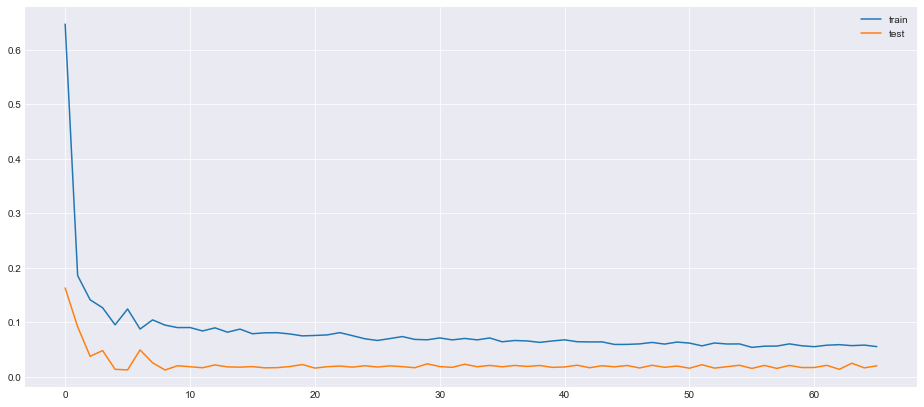

In [23]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model.hdf5')

# test test

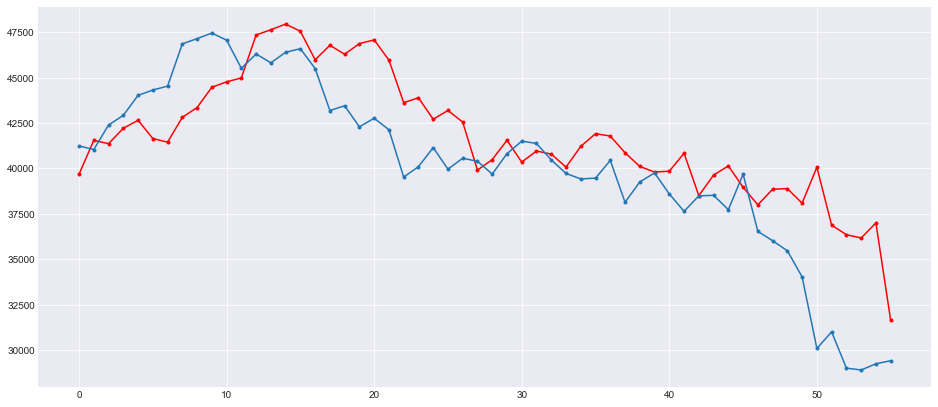

In [28]:
plt.figure(figsize=(16,7))

predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
testY_ = testY.copy()
for i in range(len(predicted_btc_price_test_data)):
    predicted_btc_price_test_data[i] = scaler_t.inverse_transform(np.array(predicted_btc_price_test_data[i] * testX[i][0][3]).reshape(-1,1))
    testY_[i] = scaler_t.inverse_transform(np.array(testY[i] * testX[i][0][3]).reshape(-1,1))
    
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(testY_, marker='.', label='Actual Test')

# test train

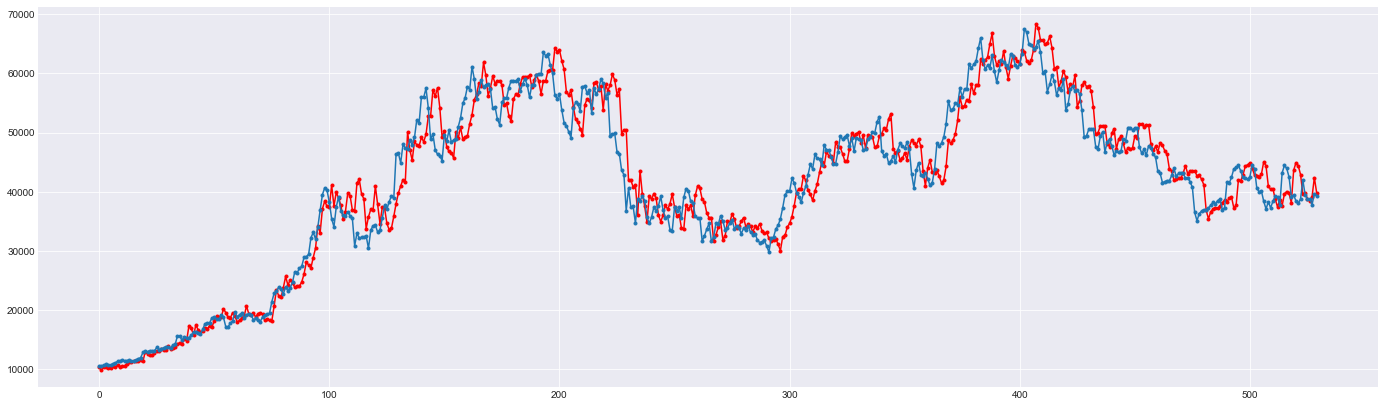

In [29]:
plt.figure(figsize=(24,7))

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
trainY_ =trainY.copy()
for i in range(len(predicted_btc_price_train_data)):
    predicted_btc_price_train_data[i] = scaler_t.inverse_transform(np.array(predicted_btc_price_train_data[i] * trainX[i][0][3]).reshape(-1,1))
    trainY_[i] = scaler_t.inverse_transform(np.array(trainY[i] * trainX[i][0][3]).reshape(-1,1))


plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
plt.plot(trainY_, marker='.', label='Actual Test')

# future

###### many to one

In [43]:
from collections import deque
SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [44]:
y_p_ = []
future_len = 180
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,1).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)
  prev_days.append(per.reshape(-1,1))
  y_p_.append(per.reshape(-1,1))
  # y_p_.append(scaler.inverse_transform(per.reshape(-1,1)))


In [45]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [46]:
actual = np.concatenate((train_actual,test_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

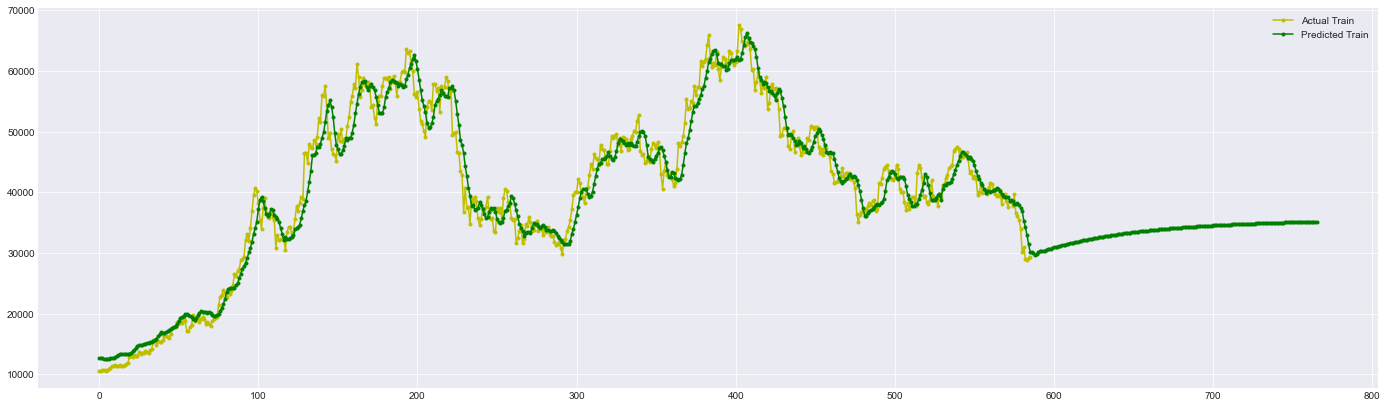

In [47]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()